In [1]:
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py

import scipy.stats as ss
from sklearn.metrics import r2_score, average_precision_score, roc_auc_score

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../CODE/')
from importlib import reload
import visualization_utils
reload(visualization_utils)
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

import shap

In [2]:
human_name_dict = {
    row['ENSEMBL']: row['HGNC'] \
    for _, row in pd.read_csv(
        '../RESOURCES/induction/hgnc_ensembl.tbl',
        sep='\t'
    ).iterrows()}

In [3]:
# HGNC --> ENSEMBL MAPPING
ensembl_name_dict = {
    row['HGNC']: row['ENSEMBL'] \
    for _, row in pd.read_csv(
        '../RESOURCES/induction/hgnc_ensembl.tbl',
        sep='\t'
    ).iterrows()}

In [125]:
ensembl_name_dict['USF2']

'ENSG00000105698'

In [4]:
algo = 'xgb'

feat_types = ['all_feats']

stats_arr = []

## Full model
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb_CPU'
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)

... working on all_feats
ENSG00000074219
ENSG00000115816
ENSG00000144161
ENSG00000141568
ENSG00000105698
ENSG00000172273
ENSG00000198176
ENSG00000162772
ENSG00000143390
ENSG00000001167
ENSG00000197905
ENSG00000143379
ENSG00000158773
ENSG00000147421
ENSG00000134138
ENSG00000179348
ENSG00000131931
ENSG00000177463
ENSG00000187098
ENSG00000123358
ENSG00000173039
ENSG00000106459
ENSG00000102145
ENSG00000185551
ENSG00000130522
ENSG00000082641
ENSG00000060138
ENSG00000177485
ENSG00000105722
ENSG00000111206
ENSG00000112658
ENSG00000126746
ENSG00000186918
ENSG00000130254
ENSG00000113658
ENSG00000177045
ENSG00000156273
ENSG00000166478
ENSG00000126561
ENSG00000160633
ENSG00000120837
ENSG00000185591


In [5]:
# list of trained TF models
subdirs = glob('{}/{}/{}/*'.format(dirpath, 'all_feats', 'xgb'))
subdirs = [basename(subdir) for subdir in subdirs]
print(subdirs)
len(subdirs)

['ENSG00000074219', 'ENSG00000115816', 'ENSG00000144161', 'ENSG00000141568', 'ENSG00000105698', 'ENSG00000172273', 'ENSG00000198176', 'ENSG00000162772', 'ENSG00000143390', 'ENSG00000001167', 'ENSG00000197905', 'ENSG00000143379', 'ENSG00000158773', 'ENSG00000147421', 'ENSG00000134138', 'ENSG00000179348', 'ENSG00000131931', 'ENSG00000177463', 'ENSG00000187098', 'ENSG00000123358', 'ENSG00000173039', 'ENSG00000106459', 'ENSG00000102145', 'ENSG00000185551', 'ENSG00000130522', 'ENSG00000082641', 'ENSG00000060138', 'ENSG00000177485', 'ENSG00000105722', 'ENSG00000111206', 'ENSG00000112658', 'ENSG00000126746', 'ENSG00000186918', 'ENSG00000130254', 'ENSG00000113658', 'ENSG00000177045', 'ENSG00000156273', 'ENSG00000166478', 'ENSG00000126561', 'ENSG00000160633', 'ENSG00000120837', 'ENSG00000185591']


42

In [6]:
stats_df = stats.copy()

In [8]:
mean_auprc = stats_df.groupby(['tf_com'])[['auprc']].mean().reset_index()
mean_auprc

,tf_com,auprc
0,ATF3,0.191845
1,BACH1,0.021593
2,CEBPZ,0.130266
3,ERF,0.423131
4,FOXK2,0.259142
5,FOXM1,0.516711
6,GATA1,0.249528
7,GATA2,0.105820
8,HINFP,0.108909
9,HMBOX1,0.011786


In [9]:
mean_auprc['tf'] = mean_auprc['tf_com'].map(ensembl_name_dict) # new column with ensembl IDs
mean_auprc

,tf_com,auprc,tf
0,ATF3,0.191845,ENSG00000162772
1,BACH1,0.021593,ENSG00000156273
2,CEBPZ,0.130266,ENSG00000115816
3,ERF,0.423131,ENSG00000105722
4,FOXK2,0.259142,ENSG00000141568
5,FOXM1,0.516711,ENSG00000111206
6,GATA1,0.249528,ENSG00000102145
7,GATA2,0.105820,ENSG00000179348
8,HINFP,0.108909,ENSG00000172273
9,HMBOX1,0.011786,ENSG00000147421


In [10]:
# read input file
df = pd.read_csv('../RESOURCES/HumanK562_TFPert/K562_pertResp_DESeq2_long.csv', sep=',')
df.head()

,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,padj
0,ARID3A,ENSG00000116017,ENSG00000000003,-0.013423,0.999934
1,ARID3A,ENSG00000116017,ENSG00000000005,0.005889,0.999934
2,ARID3A,ENSG00000116017,ENSG00000000419,0.015190,0.999934
3,ARID3A,ENSG00000116017,ENSG00000000457,-0.024851,0.999934
4,ARID3A,ENSG00000116017,ENSG00000000460,-0.002384,0.999934


In [11]:
# take subset of TFs that we have binding locations data of
df = df[df['tf_ensg'].isin(subdirs)]
df

,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,padj
19728,ATF3,ENSG00000162772,ENSG00000186652,-1.227364,1.561967e-49
19729,ATF3,ENSG00000162772,ENSG00000110876,-1.402234,3.473520e-49
19730,ATF3,ENSG00000162772,ENSG00000117984,-0.766997,1.920930e-39
19731,ATF3,ENSG00000162772,ENSG00000161011,-0.788784,3.539923e-38
19732,ATF3,ENSG00000162772,ENSG00000030582,-0.817537,4.903445e-38
...,...,...,...,...,...
1104763,ZNF395,ENSG00000186918,ENSG00000282936,0.120622,1.000000e+00
1104764,ZNF395,ENSG00000186918,ENSG00000283039,0.255575,1.000000e+00
1104765,ZNF395,ENSG00000186918,ENSG00000283071,0.017016,1.000000e+00
1104766,ZNF395,ENSG00000186918,ENSG00000283088,0.000000,1.000000e+00


In [35]:
# log2foldchange -> foldchange
df_fc = df.copy()
df_fc['FoldChange'] = df_fc.apply(lambda row : 2**abs(row['log2FoldChange']), axis=1)
df_fc

,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,padj,FoldChange
19728,ATF3,ENSG00000162772,ENSG00000186652,-1.227364,1.561967e-49,2.341388
19729,ATF3,ENSG00000162772,ENSG00000110876,-1.402234,3.473520e-49,2.643106
19730,ATF3,ENSG00000162772,ENSG00000117984,-0.766997,1.920930e-39,1.701724
19731,ATF3,ENSG00000162772,ENSG00000161011,-0.788784,3.539923e-38,1.727617
19732,ATF3,ENSG00000162772,ENSG00000030582,-0.817537,4.903445e-38,1.762395
...,...,...,...,...,...,...
1104763,ZNF395,ENSG00000186918,ENSG00000282936,0.120622,1.000000e+00,1.087204
1104764,ZNF395,ENSG00000186918,ENSG00000283039,0.255575,1.000000e+00,1.193811
1104765,ZNF395,ENSG00000186918,ENSG00000283071,0.017016,1.000000e+00,1.011864
1104766,ZNF395,ENSG00000186918,ENSG00000283088,0.000000,1.000000e+00,1.000000


In [36]:
# absl2fc = log2 ( 2^|l2fc|)
df_absl2fc = df_fc.copy()
df_absl2fc['absl2fc'] = df_fc.apply(lambda row : np.log2(2**abs(row['log2FoldChange'])), axis=1)
df_tfs = df_absl2fc.query('tf_ensg == gene_ensg').reset_index(drop=True)
df_tfs = df_tfs.set_index('tf_ensg').join(mean_auprc[['tf','auprc']].set_index('tf'))

# tf name, absl2fc, auprc
df_tfs_simp = df_tfs[['tf_hgnc','absl2fc','auprc']]
df_tfs_simp

,tf_hgnc,absl2fc,auprc
tf_ensg,,,
ENSG00000162772,ATF3,1.219755,0.191845
ENSG00000156273,BACH1,0.950358,0.021593
ENSG00000115816,CEBPZ,0.302977,0.130266
ENSG00000105722,ERF,0.977160,0.423131
ENSG00000141568,FOXK2,0.485458,0.259142
ENSG00000111206,FOXM1,0.292134,0.516711
ENSG00000102145,GATA1,0.971694,0.249528
ENSG00000179348,GATA2,0.313663,0.105820
ENSG00000172273,HINFP,0.416324,0.108909


In [70]:
# keep "responsive" target rows only (absl2fc > 0.5 AND padj < 0.05) for our select TF (USF2)
responsive_targets_df = df_absl2fc[df_absl2fc['tf_ensg'] == 'ENSG00000105698'] # select TF 
print(responsive_targets_df.shape)
print(responsive_targets_df['gene_ensg'].nunique())
responsive_targets_df = responsive_targets_df[(responsive_targets_df['absl2fc'] > 0.5) & (responsive_targets_df['padj'] < 0.05)].reset_index(drop=True)
responsive_targets_df

(19728, 7)
19728


,tf_hgnc,tf_ensg,gene_ensg,log2FoldChange,padj,FoldChange,absl2fc
0,USF2,ENSG00000105698,ENSG00000186652,-3.632720,2.997169e-243,12.403886,3.632720
1,USF2,ENSG00000105698,ENSG00000110876,-3.256095,2.542401e-150,9.553937,3.256095
2,USF2,ENSG00000105698,ENSG00000105223,-1.946970,3.293722e-146,3.855639,1.946970
3,USF2,ENSG00000105698,ENSG00000105698,-2.126733,7.845797e-113,4.367274,2.126733
4,USF2,ENSG00000105698,ENSG00000105492,-3.346036,7.885697e-113,10.168508,3.346036
...,...,...,...,...,...,...,...
5185,USF2,ENSG00000105698,ENSG00000095574,0.514632,4.938388e-02,1.428629,0.514632
5186,USF2,ENSG00000105698,ENSG00000196754,1.023733,4.951328e-02,2.033173,1.023733
5187,USF2,ENSG00000105698,ENSG00000118620,0.673507,4.951545e-02,1.594945,0.673507
5188,USF2,ENSG00000105698,ENSG00000138311,1.048834,4.970843e-02,2.068857,1.048834


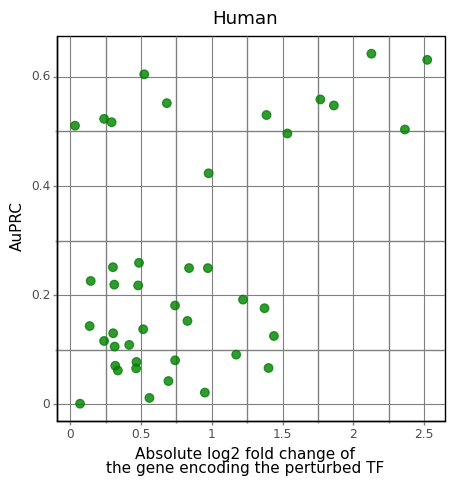

<ggplot: (8763497102049)>

In [14]:
# plot the auprc by absl2fc
theme_set(theme_bw())
gp = (ggplot(df_tfs_simp,
      aes(x='absl2fc', y='auprc'))
    
      + geom_point(alpha=0.8, color='green',size=3)
      
      + labs(title='Human',
             x='Absolute log2 fold change of\nthe gene encoding the perturbed TF',
             y='AuPRC')
      
      + theme_bw() +
        theme(line=element_line(color="gray"),
              axis_line=element_line(color="black"),
              axis_ticks=element_line(color = "black"),
              figure_size=(5,5),
              panel_border=element_line(color="black"))
     )

gp

In [15]:
# TFs with absl2fc > 1.5
big_lfc = df_tfs_simp[df_tfs_simp['absl2fc'] > 1.5]
big_lfc

,tf_hgnc,absl2fc,auprc
tf_ensg,,,
ENSG00000130522,JUND,1.766215,0.558427
ENSG00000143390,RFX5,1.861369,0.547443
ENSG00000074219,TEAD2,2.520976,0.630924
ENSG00000197905,TEAD4,1.533168,0.496063
ENSG00000198176,TFDP1,2.363133,0.503368
ENSG00000105698,USF2,2.126733,0.642159


In [16]:
# TFs names of absl2fc > 1.5
temp = big_lfc.reset_index()
genes = temp['tf_ensg'].tolist()
genes

['ENSG00000130522',
 'ENSG00000143390',
 'ENSG00000074219',
 'ENSG00000197905',
 'ENSG00000198176',
 'ENSG00000105698']

### SHAP VALUES (`shaps_df`)

In [17]:
# shap values for TFs with absl2fc > 1.5
algo = 'xgb'

dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb_CPU'
feat_types = 'all_feats'
shaps_df = parse_classifier_shap(dirpath, genes, algo, feat_types, human_name_dict)

['ENSG00000130522', 'ENSG00000143390', 'ENSG00000074219', 'ENSG00000197905', 'ENSG00000198176', 'ENSG00000105698']
ENSG00000074219
ENSG00000105698
ENSG00000198176
ENSG00000143390
ENSG00000197905
ENSG00000130522


In [23]:
print(shaps_df.shape)
shaps_df

(119536656, 5)


,tf,gene,feat_idx,feat,cv
0,ENSG00000074219,ENSG00000000971,0,0.000000,0
1,ENSG00000074219,ENSG00000001167,0,0.000000,0
2,ENSG00000074219,ENSG00000002330,0,0.000000,0
3,ENSG00000074219,ENSG00000002586,0,0.000000,0
4,ENSG00000074219,ENSG00000002933,0,0.000000,0
...,...,...,...,...,...
119536651,ENSG00000130522,ENSG00000278057,1051,0.038595,9
119536652,ENSG00000130522,ENSG00000278129,1051,-0.600836,9
119536653,ENSG00000130522,ENSG00000278828,1051,-0.633744,9
119536654,ENSG00000130522,ENSG00000279051,1051,-0.264563,9


## FEATURE MATRIX (`feat_mtx_df`) of single TF (USF2)

> TODO: UPDATE `parse_classifier_feat` TO TAKE IN LIST OF TF'S AS ARGUMENT AND RETURN DATAFRAME OF MULTIPLE TFS FEATURE MATRICES

In [71]:
# feature matrix for single TF
algo = 'xgb'

dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb_CPU'
feat_types = 'all_feats'
feat_mtx_df = parse_classifier_feat(dirpath, ['ENSG00000105698'], algo, feat_types, human_name_dict)

['ENSG00000105698']
(0, 1052)
ENSG00000105698
(18938, 1052)
(18938, 1052)


In [72]:
print(feat_mtx_df.shape)
feat_mtx_df

(18938, 1052)


,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat1042,feat1043,feat1044,feat1045,feat1046,feat1047,feat1048,feat1049,feat1050,feat1051
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.119690,0.060242,0.114319,0.098633,0.013069,0.099243,0.035187,0.057983,1.792392,0.043638
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.104004,0.052368,0.098633,0.072021,0.003626,0.083008,0.029633,0.047638,0.301030,0.239432
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.077454,0.035461,0.080872,0.068115,0.017609,0.066101,0.035004,0.029160,4.805038,-0.000185
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.099915,0.049225,0.092285,0.073791,0.010750,0.083496,0.031555,0.044647,3.551694,-0.037481
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093445,0.048126,0.087463,0.064087,0.007130,0.078918,0.026550,0.043152,4.257006,0.001709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.043121,0.017868,0.046112,0.050873,0.008873,0.036499,0.021744,0.012375,0.301030,0.061091
18934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.126099,0.040955,0.120361,0.111206,0.010635,0.101074,0.045715,0.031342,1.716003,0.113645
18935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.056000,0.014503,0.059265,0.069519,0.013748,0.042999,0.033264,0.008247,0.301030,0.052958
18936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.118225,0.031250,0.122742,0.141479,0.023254,0.098022,0.053497,0.020996,0.301030,-0.806609


## PREDICTIONS 

In [25]:
file = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb_CPU/all_feats/xgb/ENSG00000105698/preds.csv.gz'
preds_df = pd.read_csv(file, header=0)
preds_df

,gene,cv,label,pred
0,ENSG00000000005,0,0,0.051743
1,ENSG00000000457,0,0,0.097568
2,ENSG00000000460,0,1,0.319644
3,ENSG00000002587,0,1,0.170498
4,ENSG00000003137,0,1,0.302523
...,...,...,...,...
18933,ENSG00000276600,9,0,0.152091
18934,ENSG00000277972,9,0,0.574487
18935,ENSG00000278540,9,0,0.209999
18936,ENSG00000278677,9,0,0.435073


## LIST OF GENES (`genes_df`)

In [1]:
file = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb_CPU/all_feats/xgb/ENSG00000105698/genes.csv.gz'
genes_df = pd.read_csv(file, header=None, names=['gene'])
genes_df

NameError: name 'pd' is not defined

In [73]:
# add respective genes to feature matrix
feat_mtx_resp_df = feat_mtx_df.copy()
feat_mtx_resp_df.index = genes_df['gene']

# filter out non-responsive target genes
feat_mtx_resp_df = feat_mtx_resp_df[feat_mtx_resp_df.index.isin(responsive_targets_df['gene_ensg'])]
feat_mtx_resp_df

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat1042,feat1043,feat1044,feat1045,feat1046,feat1047,feat1048,feat1049,feat1050,feat1051
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093445,0.048126,0.087463,0.064087,0.007130,0.078918,0.026550,0.043152,4.257006,0.001709
ENSG00000000938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093506,0.022858,0.088440,0.116211,0.014175,0.076477,0.037842,0.016144,0.301030,-0.016554
ENSG00000001631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.108521,0.057800,0.103455,0.080933,0.016632,0.088684,0.036194,0.058014,4.495572,0.008551
ENSG00000002330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.092590,0.016708,0.077820,0.148926,0.030106,0.075134,0.052612,0.012421,4.136150,0.040667
ENSG00000002587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.143921,0.043488,0.123657,0.148193,0.034668,0.113403,0.068115,0.040375,0.301030,0.198135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000278558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.088684,0.015343,0.069702,0.114868,0.038483,0.067688,0.060242,0.014671,3.262925,0.274214
ENSG00000280789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.131958,0.023743,0.099487,0.194946,0.041748,0.110779,0.067261,0.018997,4.332883,0.007087
ENSG00000281991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.143799,0.032745,0.126221,0.171997,0.017746,0.114258,0.053497,0.026505,2.978637,0.552656


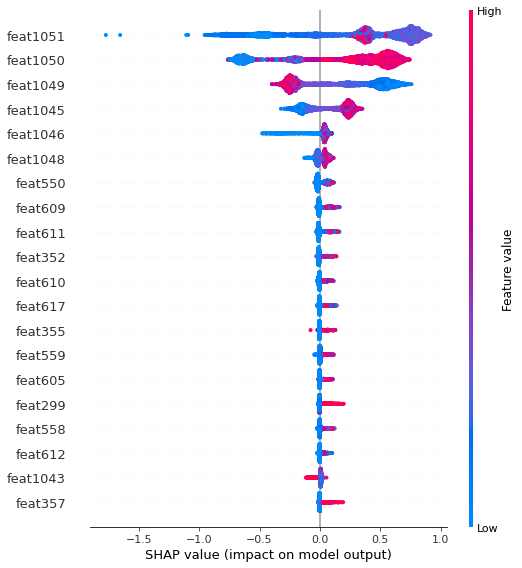

In [121]:
shap.summary_plot(shap_target_avg_df_sum.values, feat_mtx_resp_df)

In [74]:
shap_target_df

,tf,gene,feat_idx,feat,cv
19922776,ENSG00000105698,ENSG00000000005,0,0.000000,0
19922777,ENSG00000105698,ENSG00000000457,0,0.000000,0
19922778,ENSG00000105698,ENSG00000000460,0,0.000000,0
19922779,ENSG00000105698,ENSG00000002587,0,0.000000,0
19922780,ENSG00000105698,ENSG00000003137,0,0.000000,0
...,...,...,...,...,...
39845547,ENSG00000105698,ENSG00000276600,1051,-0.476827,9
39845548,ENSG00000105698,ENSG00000277972,1051,0.312653,9
39845549,ENSG00000105698,ENSG00000278540,1051,-0.047317,9
39845550,ENSG00000105698,ENSG00000278677,1051,0.702985,9


In [116]:
shap_target_avg_df = shap_target_df[['gene','feat_idx','feat','cv']]
shap_target_avg_df = shap_target_avg_df.groupby(['gene','feat_idx'], as_index=False)[['feat']].sum()
shap_target_avg_df

feat_idx,0,1,2,3,4,5,6,7,8,9,...,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000350,-0.043861,0.001437,-0.021258,0.088486,0.000000,-0.009208,-0.256096,-0.622295,0.388710
ENSG00000000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000519,0.011942,0.000766,-0.168312,-0.421917,0.000000,-0.026242,-0.240726,-0.631684,0.316871
ENSG00000000419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000677,0.010165,-0.000164,-0.159501,0.044941,0.000027,-0.018798,-0.180546,0.453971,0.354602
ENSG00000000457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001404,0.001874,-0.000926,-0.130973,0.026548,0.000000,-0.026894,-0.217188,0.308097,-0.863948
ENSG00000000460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000839,0.011340,-0.000806,-0.149327,0.055135,0.000000,-0.020439,-0.212944,0.485956,0.461785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000282419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.002315,0.012158,-0.000938,-0.136674,0.072441,0.000000,-0.128283,0.452732,-0.620293,0.428610
ENSG00000282608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000507,0.009282,0.000812,0.131404,0.034944,-0.000023,0.063008,-0.284602,-0.597194,0.394241
ENSG00000282815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.002315,0.011907,-0.000938,-0.137404,0.076154,0.000000,-0.030111,0.513068,-0.627029,0.439153


In [120]:
shap_target_avg_df_sum = shap_target_avg_df[shap_target_avg_df['gene'].isin(responsive_targets_df['gene_ensg'])].reset_index(drop=True).pivot(index='gene', columns='feat_idx', values='feat')

In [115]:
shap_target_avg_df.pivot(index='gene', columns='feat_idx', values='feat')

KeyError: 'gene'

In [83]:
shap_cv_df['gene'].value_counts().value_counts()

1052    1894
Name: gene, dtype: int64

In [86]:
len(shap_target_df['gene'].unique())

18938

In [90]:
shap_target_df['gene'].unique()

array(['ENSG00000000005', 'ENSG00000000457', 'ENSG00000000460', ...,
       'ENSG00000278540', 'ENSG00000278677', 'ENSG00000278889'],
      dtype=object)

In [92]:
2*[0]

[0, 0]

In [94]:
for i, [a,b,c,d,e] in shap_target_df.iterrows():
    print(i)
    print(a,b,c,d,e)
    break

19922776
ENSG00000105698 ENSG00000000005 0 0.0 0


In [97]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [100]:
tmp_df = pd.DataFrame(data={'gene':['a','a','a','b','b','b','a','a','a','b','b','b','c','c','c'], 'feat_idx':5*[0,1,2], 'feat':list(range(15)), 'cv':[0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,]})
tmp_df

,gene,feat_idx,feat,cv
0,a,0,0,0
1,a,1,1,0
2,a,2,2,0
3,b,0,3,0
4,b,1,4,0
5,b,2,5,0
6,a,0,6,1
7,a,1,7,1
8,a,2,8,1
9,b,0,9,1


In [105]:
d = {}
simp_df = tmp_df.copy()

for gene in simp_df['gene'].unique():
    d[gene] = 3*[0]

for cv in range(2):
    cv_df = simp_df[simp_df['cv'] == cv].drop(columns=['cv'])
    
    for i, [gene, idx, feat] in cv_df.iterrows():
        d[gene][idx] += feat
        
d

{'a': [6, 8, 10], 'b': [12, 14, 16], 'c': [12, 13, 14]}

In [110]:
tmp_df.groupby(['feat_idx','gene'])['feat'].sum()

feat_idx  gene
0         a        6
          b       12
          c       12
1         a        8
          b       14
          c       13
2         a       10
          b       16
          c       14
Name: feat, dtype: int64

In [96]:
D = {}
simp_df = shap_target_df[['gene','feat_idx','feat','cv']]

for gene in simp_df['gene'].unique():
    D[gene] = 1052*[0]

for cv in range(10):
    cv_df = simp_df[simp_df['cv'] == cv].drop(columns=['cv'])
    
    for i, [gene, idx, feat] in cv_df.iterrows():
        D[gene][idx] += feat
    
    break

## Pick out our perturbed TFs from shap value df for first fold of CV

In [24]:
shap_target_df = shaps_df[shaps_df['tf']=='ENSG00000105698'] # perturbed TF
shap_cv_df = shap_target_df[shap_target_df['cv']==0] # first fold
shap_cv_df

,tf,gene,feat_idx,feat,cv
19922776,ENSG00000105698,ENSG00000000005,0,0.000000,0
19922777,ENSG00000105698,ENSG00000000457,0,0.000000,0
19922778,ENSG00000105698,ENSG00000000460,0,0.000000,0
19922779,ENSG00000105698,ENSG00000002587,0,0.000000,0
19922780,ENSG00000105698,ENSG00000003137,0,0.000000,0
...,...,...,...,...,...
21915259,ENSG00000105698,ENSG00000277443,1051,-0.452990,0
21915260,ENSG00000105698,ENSG00000277632,1051,0.367440,0
21915261,ENSG00000105698,ENSG00000278505,1051,0.349977,0
21915262,ENSG00000105698,ENSG00000282419,1051,0.428610,0


In [28]:
shap_cv_df = shap_cv_df[['gene','feat_idx','feat']].reset_index(drop=True) # drop cv and tf which are all the same
shap_cv_df

,gene,feat_idx,feat
0,ENSG00000000005,0,0.000000
1,ENSG00000000457,0,0.000000
2,ENSG00000000460,0,0.000000
3,ENSG00000002587,0,0.000000
4,ENSG00000003137,0,0.000000
...,...,...,...
1992483,ENSG00000277443,1051,-0.452990
1992484,ENSG00000277632,1051,0.367440
1992485,ENSG00000278505,1051,0.349977
1992486,ENSG00000282419,1051,0.428610


In [41]:
# PICK OUT ONLY RESPONSIVE TARGET GENES
shap_cv_resp_df = shap_cv_df[shap_cv_df['gene'].isin(responsive_targets_df['gene_ensg'])].reset_index(drop=True)
shap_cv_resp_df

,gene,feat_idx,feat
0,ENSG00000000460,0,0.000000
1,ENSG00000002587,0,0.000000
2,ENSG00000003137,0,0.000000
3,ENSG00000006451,0,0.000000
4,ENSG00000010361,0,0.000000
...,...,...,...
538619,ENSG00000275074,1051,0.718863
538620,ENSG00000277203,1051,0.394642
538621,ENSG00000277363,1051,-0.441731
538622,ENSG00000282419,1051,0.428610


In [ ]:
#shapcv0_simp[shapcv0_simp['gene']=='ENSG00000000005']

In [55]:
# pivot (unstack) s.t. indexed by gene and columns are feature indices with shap values as entries
# LONG --> WIDE
shap_cv_resp_df_pivot = shap_cv_resp_df.pivot(index='gene', columns='feat_idx', values='feat')

# export list of genes (index of df)
resp_genes_list = (shap_cv_resp_df_pivot.index.values)
print(len(resp_genes_list))

# RENAME COLUMNS FROM i --> feati 
shap_cv_resp_df_pivot.columns = ['feat{}'.format(i) for i in shap_cv_resp_df_pivot.columns]
shap_cv_resp_df_pivot = shap_cv_resp_df_pivot.reset_index(drop=True) # remove index (gene names)
shap_cv_resp_df_pivot

512


,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat1042,feat1043,feat1044,feat1045,feat1046,feat1047,feat1048,feat1049,feat1050,feat1051
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000839,0.011340,-0.000806,-0.149327,0.055135,0.0,-0.020439,-0.212944,0.485956,0.461785
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000519,0.011479,0.000950,0.185150,0.080453,0.0,0.040344,-0.260873,-0.597470,0.377272
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001551,0.011608,0.001155,0.193707,0.066608,0.0,0.084386,0.332609,-0.603310,0.421745
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000839,0.010224,-0.000806,-0.130793,0.070606,0.0,-0.038983,-0.222434,0.522047,0.753280
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.011803,0.010009,-0.001739,0.097522,0.042757,0.0,-0.038163,0.540553,0.329797,-0.822185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001551,0.010918,0.001155,0.277895,0.053257,0.0,0.085226,0.549383,0.372775,0.718863
508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000839,0.011947,-0.000806,-0.145170,0.094785,0.0,-0.037007,-0.193098,-0.602370,0.394642
509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007850,0.009852,0.002387,0.246526,0.046774,0.0,0.098787,0.458989,-0.161061,-0.441731
510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.002315,0.012158,-0.000938,-0.136674,0.072441,0.0,-0.128283,0.452732,-0.620293,0.428610


## Plain summary plot for USF2

In [ ]:
shapcv0_simp_pivot.reset_index(drop=True)

In [ ]:
feat_clean.reset_index(drop=True)

In [61]:
shap_cv_resp_df_pivot.shape

(512, 1052)

In [119]:
feat_mtx_df.shape

(18938, 1052)

In [59]:
shap.summary_plot(shap_cv_resp_df_pivot, feat_mtx_df.reset_index(drop=True))

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

## Plain summary plot for binned features for USF2

In [ ]:
# bin the features based on how features were organized
feats_dir = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb_CPU/all_feats/xgb/ENSG00000105698/feats.csv.gz'

feats_org_df = pd.read_csv(feats_dir, header=None, sep=",", names=['feat','subfeat','start','end'])
feats_org_df

In [27]:
def clean_feats(feats_df):
    idxs = [0,7]
    
    # tf_binding & chrom acc
    for idx in idxs:
        feats_df.loc[idx, 'subfeat'] = feats_df.loc[idx,'feat']
        
    # dinucleotides
    dna = feats_df[feats_df['feat']=='dna_sequence_nt_freq']
    start = dna['start'].values[0]
    end = dna['end'].values[-1]
    
    idx = dna.index[0]
    
    feats_org_df.loc[idx] = ['dna','Dinucleotides',start,end]
    
    # GEX
    feats_df = feats_df.replace({'median_level':'GEX level', 'variation':'GEX var'})
    
    feats_df = feats_df[feats_df['feat'] != 'dna_sequence_nt_freq']
    
    feats_df = feats_df.drop(columns=['feat']).reset_index(drop=True)
    
    feats_df = feats_df.rename(columns={'subfeat':'feat'})
    
    return feats_df

def group_by_features(feat_df, grouping_df):
    
    df = pd.DataFrame()

    for idx, row in grouping_df.iterrows():

        feat = row['feat']
        start = row['start']
        end = row['end']

        col_names = ['feat{}'.format(i) for i in range(start,end)]

        # sum up respective columns
        sum_feat_col = feat_df[col_names].sum(axis=1)

        # add column to dataset
        df[feat] = sum_feat_col

        # remove columns that were summed
#         feat_df.drop(col_names)

    return df

def group_by_features_abs(feat_df, grouping_df):
    
    df = pd.DataFrame()

    for idx, row in grouping_df.iterrows():

        feat = row['feat']
        start = row['start']
        end = row['end']

        col_names = ['feat{}'.format(i) for i in range(start,end)]

        # sum up respective columns
        sum_feat_col = feat_df[col_names].abs().sum(axis=1)

        # add column to dataset
        df[feat] = sum_feat_col

        # remove columns that were summed
#         feat_df.drop(col_names)

    return df

In [ ]:
clean_feats_df = clean_feats(feats_org_df)
clean_feats_df

In [ ]:
grouped_shap = group_by_features(shapcv0_simp_pivot, clean_feats_df)
grouped_shap

In [ ]:
grouped_df = group_by_features(feat_clean, clean_feats_df)
grouped_df

In [ ]:
grouped_df['tf_binding'].sum()

In [ ]:
np.sum(grouped_df == grouped_abs_df)

In [ ]:
grouped_abs_df['tf_binding'].sum()

In [ ]:
grouped_abs_df = group_by_features_abs(feat_clean, clean_feats_df)
grouped_abs_df

In [ ]:
empty = np.empty(shape=(1894,11))

In [ ]:
feat_name_df = pd.DataFrame(empty, columns=grouped_df.columns)
feat_name_df

In [ ]:
shap.summary_plot(grouped_abs_df.values, feat_name_df, plot_type='bar')

In [ ]:
shap.summary_plot(grouped_df.values, feat_name_df)

In [ ]:
import xgboost

In [ ]:
N = 2000
X = np.zeros((N,5))
X[:1000,0] = 1
X[:500,1] = 1
X[1000:1500,1] = 1
X[:250,2] = 1
X[500:750,2] = 1
X[1000:1250,2] = 1
X[1500:1750,2] = 1
X[:,0:3] -= 0.5
y = 2*X[:,0] - 3*X[:,1]

In [ ]:
X

In [ ]:
y.shape

In [ ]:
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({
    'eta':1, 'max_depth':3, 'base_score': 0, "lambda": 0
}, Xd, 1)
print("Model error =", np.linalg.norm(y-model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])


In [ ]:
pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)

In [ ]:
shap_values.shape